<a href="https://colab.research.google.com/github/Ixiondbz/CSE499/blob/main/RCNN_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install -U plotly

import json
from pathlib import Path
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from tqdm import tqdm
import pandas as pd
import random
import cv2

import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.utils.layer_utils import get_source_inputs
#from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from tensorflow.keras.metrics import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
#tf.keras.layers.InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers, regularizers

In [3]:
from google.colab import drive
drive.mount('/drive')

folder = "MyDrive/MIDOG_Challenge" #@param {type:"string"}
midog_folder = Path("/drive") / Path(folder)

print(list(midog_folder.glob("*.*")))

Mounted at /drive
[PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.sqlite'), PosixPath('/drive/MyDrive/MIDOG_Challenge/MIDOG.json')]


In [ ]:
!apt-get install python3-openslide
from openslide import open_slide

In [5]:
image_folder = midog_folder / "images"

hamamatsu_rx_ids = list(range(0, 51))
hamamatsu_360_ids = list(range(51, 101))
aperio_ids = list(range(101, 151))
leica_ids = list(range(151, 201))


annotation_file = midog_folder / "MIDOG.json"
rows = []
with open(annotation_file) as f:
    data = json.load(f)

    categories = {1: 'mitotic figure', 2: 'hard negative'}

    for row in data["images"]:
        file_name = row["file_name"]
        image_id = row["id"]
        width = row["width"]
        height = row["height"]

        scanner  = "Hamamatsu XR"
        if image_id in hamamatsu_360_ids:
            scanner  = "Hamamatsu S360"
        if image_id in aperio_ids:
            scanner  = "Aperio CS"
        if image_id in leica_ids:
            scanner  = "Leica GT450"
         
        for annotation in [anno for anno in data['annotations'] if anno["image_id"] == image_id]:
            box = annotation["bbox"]
            cat = categories[annotation["category_id"]]

            rows.append([file_name, image_id, width, height, box, cat, scanner])

df = pd.DataFrame(rows, columns=["file_name", "image_id", "width", "height", "box", "cat", "scanner"])

In [11]:
df.dtypes

file_name    object
image_id      int64
width         int64
height        int64
box          object
cat          object
scanner      object
dtype: object

In [12]:
df['box']

0               [4336, 346, 4386, 396]
1                 [756, 872, 806, 922]
2               [270, 4044, 320, 4094]
3       [6672.5, 706.5, 6722.5, 756.5]
4               [1872, 319, 1922, 369]
                     ...              
4430            [569, 4276, 619, 4326]
4431          [3730, 4538, 3780, 4588]
4432          [4318, 4138, 4368, 4188]
4433          [5643, 1318, 5693, 1368]
4434      [2681.5, 2846, 2731.5, 2896]
Name: box, Length: 4435, dtype: object

In [ ]:
!pip install -U object-detection-fastai

from object_detection_fastai.helper.wsi_loader import *

In [14]:
def sample_function(y, classes, size, level_dimensions, level):
    width, height = level_dimensions[level]
    if len(y[0]) == 0:
        return randint(0, width - size[0]), randint(0, height -size[1])
    else:
        #if randint(0, 5) < 2:
        if True:
            class_id = np.random.choice(classes, 1)[0] # select a random class
            ids = np.array(y[1]) == class_id # filter the annotations according to the selected class
            xmin, ymin, _, _ = np.array(y[0])[ids][randint(0, np.count_nonzero(ids) - 1)] # randomly select one of the filtered annotatons as seed for the training patch
            
            # To have the selected annotation not in the center of the patch and an random offset.
            xmin += random.randint(-size[0]/2, size[0]/2) 
            ymin += random.randint(-size[1]/2, size[1]/2)
            xmin, ymin = max(0, int(xmin - size[0] / 2)), max(0, int(ymin -size[1] / 2))
            xmin, ymin = min(xmin, width - size[0]), min(ymin, height - size[1])
            return xmin, ymin
        else:
            return randint(0, width - size[0]), randint(0, height -size[1])

            
def create_wsi_container(annotations_df: pd.DataFrame):
    container = []

    for image_name in tqdm(annotations_df["file_name"].unique()):
        image_annos = annotations_df[annotations_df["file_name"] == image_name]

        bboxes = [box   for box   in image_annos["box"]]
        labels = [label for label in image_annos["cat"]]

        container.append(SlideContainer(image_folder/image_name, y=[bboxes, labels], level=res_level,width=patch_size, height=patch_size, sample_func=sample_function))
    return container

train_scanner = "Hamamatsu XR" #@param ["Hamamatsu XR", "Hamamatsu S360", "Aperio CS"]  {allow-input: true}
val_scanner = "Hamamatsu S360" #@param ["Hamamatsu XR", "Hamamatsu S360", "Aperio CS"]  {allow-input: true}

patch_size = 256 #@param [256, 512, 1024]
res_level = 0

train_annos = df[df["scanner"].isin(train_scanner.split(","))]
train_container = create_wsi_container(train_annos)

val_annos = df[df["scanner"].isin(val_scanner.split(","))]
valid_container = create_wsi_container(val_annos)

f"Created: {len(train_container)} training WSI container and {len(valid_container)} validation WSI container"


train_samples_per_scanner = 50 #@param {type:"integer"}
val_samples_per_scanner = 10 #@param {type:"integer"}

train_images = list(np.random.choice(train_container, train_samples_per_scanner))
valid_images = list(np.random.choice(valid_container, val_samples_per_scanner))

100%|██████████| 50/50 [01:17<00:00,  1.55s/it]


In [15]:
batch_size = 12 #@param {type:"integer"}

#@markdown Lets add some basic data [augmentation](https://docs.fast.ai/vision.augment.html)
do_flip = True #@param {type:"boolean"}
flip_vert = True #@param {type:"boolean"}
max_rotate = 90 #@param {type:"number"}
max_zoom = 1.1 #@param {type:"number"}
max_lighting = 0.2 #@param {type:"number"}
max_warp = 0.2 #@param {type:"number"}
p_affine = 0.75 #@param {type:"number"}
p_lighting = 0.75 #@param {type:"number"}


tfms = get_transforms(do_flip=do_flip,
                      flip_vert=flip_vert,
                      max_rotate=max_rotate,
                      max_zoom=max_zoom,
                      max_lighting=max_lighting,
                      max_warp=max_warp,
                      p_affine=p_affine,
                      p_lighting=p_lighting)

train, valid = ObjectItemListSlide(train_images), ObjectItemListSlide(valid_images)
item_list = ItemLists(".", train, valid)
lls = item_list.label_from_func(lambda x: x.y, label_cls=SlideObjectCategoryList)
lls = lls.transform(tfms, tfm_y=True, size=patch_size)
data = lls.databunch(bs=batch_size, collate_fn=bb_pad_collate,num_workers=0).normalize()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [23]:
image_folder
image_folder+'001.tiff'

PosixPath('/drive/MyDrive/MIDOG_Challenge/images')

In [26]:
image = plt.imread(image_folder/"001.tiff")

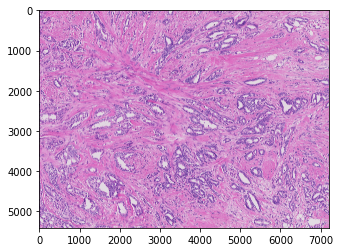

In [32]:
plt.imshow(image)

In [45]:
df['cat'].value_counts()

hard negative     2714
mitotic figure    1721
Name: cat, dtype: int64

In [58]:
df[(df['file_name']=='001.tiff')].box[0]

[4336, 346, 4386, 396]

In [108]:
for i in range(len(df)):
  if(df['box'][i]==[4336,346,4386,396]):
    print(df['box'][i])

[4336, 346, 4386, 396]


In [94]:
df['file_name']=='001.tiff'

0        True
1        True
2        True
3        True
4       False
        ...  
4430    False
4431    False
4432    False
4433    False
4434    False
Name: file_name, Length: 4435, dtype: bool

In [112]:
import ast
df['box'] = df['box'].apply(lambda x: ast.literal_eval(x))
x=np.array(list(df['box']))

for i,dim in enumerate([ 'x', 'y', 'w', 'h' ]):
	df[dim] = x[:, i]

df.drop('box', axis=1, inplace=True)
df.head()

ValueError: ignored

In [ ]:
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

#plot the image
plt.imshow(image)

# iterating over the image for different objects
for _,row in df[df.file_name == "001.tiff"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax
    
    width = xmax - xmin
    height = ymax - ymin
    
    # assign different color to different classes of objects
    if row.cat == 'RBC':
        edgecolor = 'r'
        ax.annotate('RBC', xy=(xmax-40,ymin+20))
    elif row.cat == 'WBC':
        edgecolor = 'b'
        ax.annotate('WBC', xy=(xmax-40,ymin+20))
    elif row.cat == 'Platelets':
        edgecolor = 'g'
        ax.annotate('Platelets', xy=(xmax-40,ymin+20))
        
    # add bounding boxes to the image
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')
    
    ax.add_patch(rect)